In [23]:
import os
import zipfile
import urllib.request
import ssl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pyGMs library
import pyGMs as gm
import pyGMs.ising
import pyGMs.wmb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Download Dataset

In [24]:
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"
zip_file = "ml-latest.zip"
extract_folder = "ml-latest"

# Mac workaround (only if needed)
ssl._create_default_https_context = ssl._create_unverified_context

if not os.path.exists(extract_folder):
    print("Downloading MovieLens dataset...")
    urllib.request.urlretrieve(dataset_url, zip_file)
    print("Extracting...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
    print("Done.")
else:
    print("Dataset already exists.")


Dataset already exists.


# Save User Data

In [25]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
with open("run_history.txt", "a") as f:
        f.write(f"\n{'='*50}\n")
        f.write(f"Run at: {timestamp}\n")
def save_run_data( outputs, filename="run_history.txt"):
    """
    Save run parameters and outputs to a text file
    
    Args:
        user_count: Number of users
        movie_count: Number of movies
        C: Regularization parameter
        outputs: Dictionary of outputs to save
        filename: Name of the file to save to
    """
    
    with open(filename, "a") as f:
        for key, value in outputs.items():
            f.write(f"  {key}: {value}\n")

In [26]:
ratings = pd.read_csv('ml-latest/ratings.csv')
user_count = 1000
movie_count = 250
# Filter top users/movies
top_users = ratings['userId'].value_counts().head(user_count).index
top_movies = ratings['movieId'].value_counts().head(movie_count).index


filtered = ratings[(ratings['userId'].isin(top_users)) & (ratings['movieId'].isin(top_movies))]
pivot = filtered.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Binary matrix: 1 if liked (rating ≥ 4), else 0
X = (pivot >= 4.0).astype(int).to_numpy()


In [27]:
movies = pd.read_csv(os.path.join(extract_folder, 'movies.csv'))
id_to_title = dict(zip(movies['movieId'], movies['title']))

# Build a short label dictionary for visualization
short = {i: id_to_title[mid] for i, mid in enumerate(pivot.columns)}
print(short)


{0: 'Toy Story (1995)', 1: 'Jumanji (1995)', 2: 'Heat (1995)', 3: 'GoldenEye (1995)', 4: 'Casino (1995)', 5: 'Sense and Sensibility (1995)', 6: 'Ace Ventura: When Nature Calls (1995)', 7: 'Get Shorty (1995)', 8: 'Leaving Las Vegas (1995)', 9: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 10: 'Babe (1995)', 11: 'Dead Man Walking (1995)', 12: 'Clueless (1995)', 13: 'Seven (a.k.a. Se7en) (1995)', 14: 'Usual Suspects, The (1995)', 15: "Mr. Holland's Opus (1995)", 16: 'Broken Arrow (1996)', 17: 'Happy Gilmore (1996)', 18: 'Braveheart (1995)', 19: 'Taxi Driver (1976)', 20: 'Birdcage, The (1996)', 21: 'Apollo 13 (1995)', 22: 'Batman Forever (1995)', 23: 'Crimson Tide (1995)', 24: 'Die Hard: With a Vengeance (1995)', 25: 'Net, The (1995)', 26: 'Waterworld (1995)', 27: 'Clerks (1994)', 28: 'Dumb & Dumber (Dumb and Dumber) (1994)', 29: 'Interview with the Vampire: The Vampire Chronicles (1994)', 30: 'Star Wars: Episode IV - A New Hope (1977)', 31: 'Natural Born Killers (1994)', 32: 'Outbreak (199

In [28]:
Xtr, Xte = train_test_split(X, test_size=0.2, random_state=42)
nMovies = Xtr.shape[1]


In [29]:
pXi = np.mean(Xtr, axis=0)
model0 = gm.GraphModel([gm.Factor([gm.Var(i, 2)], [1 - pXi[i], pXi[i]]) for i in range(nMovies)])

print("Independent model Train LL:", np.mean([model0.logValue(x) for x in Xtr]))
print("Independent model Test  LL:", np.mean([model0.logValue(x) for x in Xte]))


Independent model Train LL: -155.09829868656539
Independent model Test  LL: -155.68010474922153


In [30]:
from sklearn.linear_model import LogisticRegression

C = 0.045  # Regularization strength
nbrs, th_ij, th_i = [None] * nMovies, [None] * nMovies, np.zeros((nMovies,))
Xtmp = np.copy(Xtr)

for i in range(nMovies):
    Xtmp[:, i] = 0.
    lr = LogisticRegression(penalty='l1', C=C, solver='liblinear').fit(Xtmp, Xtr[:, i])
    nbrs[i] = np.where(np.abs(lr.coef_) > 1e-6)[1]
    th_ij[i] = lr.coef_[0, nbrs[i]] / 2.
    th_i[i] = lr.intercept_ / 2.
    Xtmp[:, i] = Xtr[:, i]

print("Average connectivity at C =", C, ":", np.mean([len(nn) for nn in nbrs]))

save_run_data(
    outputs={
        "Initial Parameters": f"Users: {user_count}, Movies: {movie_count}, C: {C}"
    }
)

save_run_data(
    outputs={
        "Average Connectivity": f"{np.mean([len(nn) for nn in nbrs])} +/- {np.std([len(nn) for nn in nbrs])}"
    }
)

Average connectivity at C = 0.045 : 10.484


In [31]:
factors = [gm.Factor(gm.Var(i, 2), [-t, t]).exp() for i, t in enumerate(th_i)]
for i in range(nMovies):
    for j, n in enumerate(nbrs[i]):
        scope = [gm.Var(i, 2), gm.Var(int(n), 2)]
        t = th_ij[i][j]
        factors.append(gm.Factor(scope, [[t, -t], [-t, t]]).exp())

model1 = gm.GraphModel(factors)
model1.makeMinimal()


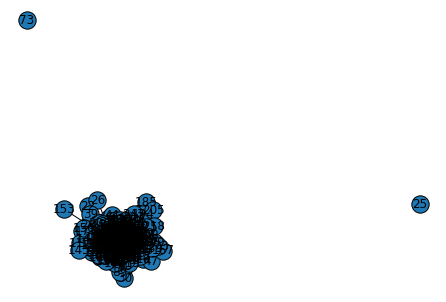

In [32]:
# Print mapping of movie indices to titles
# print("Movie Index to Title Mapping:")
# print("-" * 40)
# for var in model1.vars:
#     print(f"Movie {var.label}: {short[var.label]}")
# print("-" * 40)

# Draw graph with numeric labels
short_labels = {var.label: var.label for var in model1.vars}
gm.drawMarkovGraph(model1, labels=short_labels)


In [ ]:
order, _ = gm.eliminationOrder(model1, 'minfill')
jt = gm.wmb.JTree(model1, elimOrder=order)
lnZ = jt.msgForward()

print("Log partition function:", lnZ)
print("Ising Train LL:", np.mean([model1.logValue(x) for x in Xtr]) - lnZ)
print("Ising Test LL:", np.mean([model1.logValue(x) for x in Xte]) - lnZ)

# Save log likelihood results
save_run_data(
    outputs={
        "LogReg Ising Train LL": np.mean([model1.logValue(x) for x in Xtr]) - lnZ,
        "LogReg Ising Test LL": np.mean([model1.logValue(x) for x in Xte]) - lnZ
    }
)

In [11]:
def conditional(factor, i, x):
    return factor.t[tuple(x[v] if v != i else slice(v.states) for v in factor.vars)]

def pseudolikelihood(model, X):
    LL = np.zeros(X.shape)
    for i in range(X.shape[1]):  # for each variable (movie)
        flist = model.factorsWith(i, copy=False)
        for j in range(X.shape[0]):  # for each data point (user)
            pXi = 1.
            for f in flist:
                pXi *= conditional(f, i, X[j])
            LL[j, i] = np.log(pXi[X[j, i]] / pXi.sum())
    return LL.sum(1)


In [ ]:
print("Pseudo-likelihood (Train):", pseudolikelihood(model1, Xtr).mean())
print("Pseudo-likelihood (Test):", pseudolikelihood(model1, Xte).mean())

save_run_data(
    outputs={
        "Model0 Pseudolikelihood": pseudolikelihood(model0, Xte).mean(),
        "Model1 Pseudolikelihood": pseudolikelihood(model1, Xte).mean()
    }
)

In [13]:
def impute_missing(model, Xobs):
    m,n = Xobs.shape
    Xhat = np.copy(Xobs);
    for j in range(m):
        x_obs = {i:Xobs[j,i] for i in range(n) if Xobs[j,i] >= 0}
        x_unobs = [i for i in range(n) if Xobs[j,i] < 0]
        cond = gm.GraphModel([f.condition(x_obs) for f in model.factorsWithAny(x_unobs)])
        for x in cond.X:
            if x.states == 0: x.states = 1;  # fix a bug in GraphModel behavior for missing vars...
        jt = gm.wmb.JTree(cond, weights=1e-6) # 0: for maximization
        x_hat = jt.argmax();
        for i in x_unobs: Xhat[j,i] = x_hat[i]
    return Xhat

In [ ]:
# Create a copy of Xte to simulate missing values
Xte_missing = np.copy(Xte)

#  Amount of test data that will be hidden
missing_proportion = 0.2

# Random seed for reproducibility
np.random.seed(42)

# Boolean mask where True means that position is missing and apply it to Xte_missing
mask = np.random.rand(*Xte.shape) < missing_proportion

# Set the selected entries to a missing indicator
Xte_missing[mask] = -1

In [ ]:
# Slow!  (Constructing lots of conditional models...)
Xte_hat = impute_missing(model1, Xte_missing)

# Compare the imputed values (Xte_hat) with the original true values (Xte)
error_rate = np.mean(Xte_hat[mask] != Xte[mask])

print('Error rate:', error_rate)


save_run_data(
    outputs={
        "Error Rate": np.mean((Xte_hat!=Xte_missing)[Xte_hat<0])
    }
)